## package import

In [1]:

#import libraries
import cytoflow as flow

# mpl.use('TkAgg')
from itertools import product
import os
%matplotlib inline
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import sklearn
import sys
from scipy.special import factorial
import re
import statistics as stats
import itertools
from matplotlib.lines import Line2D
from pandas.api.types import CategoricalDtype
from scipy.stats import spearmanr

In [2]:
mpl.rcParams['font.sans-serif'] = "Helvetica Neue"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42 # make labels editable in pdf

mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 1

sns.set_style("ticks")
sns.set_context("talk", font_scale = 0.5)
mpl.rc('figure', dpi = 160)

## data import

In [3]:
# list the directories where you want to search for FCS files
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_KRAB/'
dataDir = ['20220301_A6B9-KRAB_dox5days_release16/',
           '20220305_A6B9-KRABmut147-150-140_dox5days_release16/',
           '20220628_A6B9-KRABmut150_dox1day_release16',
           '20220713_A6B9-KRABmut147_dox1day_release16',
           '20240106_B9-KRAB_dox1day_release16']

separator_list = '_rep|_dox|_rec|_release' # modifly the next cell accordingly

In [4]:
#the following is copied directly from one of Connor's notebooks:
def find_tubes(fcsList, path, item):
    itempath = os.path.join(path, item)
    if os.path.isdir(itempath):
        for subitem in os.listdir(itempath):
            find_tubes(fcsList, itempath, subitem)
    elif '.fcs' in itempath:
        fcsList.append(itempath)
    return fcsList

fcsList = []

# find FCS files in the directories specified above
for path in dataDir:
    dataDirList = os.listdir(ZE5rawdatapath+path)
    for dirs in dataDirList:
        fcsList = find_tubes(fcsList, ZE5rawdatapath+path, dirs)

tubeList = []
for file in fcsList:
    file_elements = re.split(separator_list,file.split('/')[-1].split(' ')[1][:-4]) # remove well and .fcs, then split based on underscores
    target = file_elements[0]
    rep = int(file_elements[1])
    dox = int(file_elements[2])
    rec = float(file_elements[3])
    rel = int(file_elements[4])
    # rep = int(file_elements[-1].split('.')[0].split('p')[-1])
    tubeList.extend([flow.Tube(conditions = {'dox':dox,
                                             'rec':rec,
                                             'rel':rel,
                                        'target':target,
                                        'rep':rep,},
                          file = file,
                          conditions_list = ["dox", "rec", "rel", "target", "rep"])])

In [ ]:
fcsList

In [5]:
#import tubes
op_0 = flow.ImportOp(conditions = {'dox':'int', 'rel':'int', 'rec':'float', 'target':'category', 'rep':'int'},
                tubes = tubeList, ignore_v=['FSC 488/10-A','FSC 488/10-H','FSC 488/10-W','SSC 488/10-A','SSC 488/10-W','SSC 488/10-H','mCitrine-A','mCitrine-W','mCitrine-H'])
ex_0 = op_0.apply()

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TLSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TMSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel Event Info, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel FSC 488/10-H, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400

## set gating

Percent of events in P1 gate: 89.9%


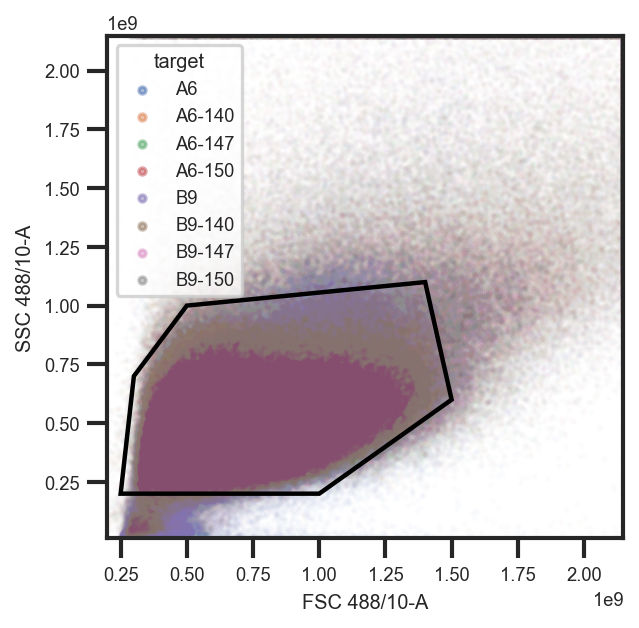

In [6]:
#draw a polygon gate around live cells
op_1 = flow.PolygonOp(
    xchannel='FSC 488/10-A',
    # vertices=[(3e8, 7e8),(1e9, 1.8e9),(1.5e9, 1.95e9),(1.3e9, 6e8),(9e8, 2e8),(4.5e8, 2e8)], # originally [(5e8, 1.3e9), (9e8, 1.8e9),(1.3e9, 1.9e9),(1e9, 6e8),(7e8, 3e8),(3e8, 3e8)]
    vertices=[(3e8, 7e8),(0.5e9, 1e9),(1.4e9, 1.1e9),(1.5e9, 6e8),(1e9, 2e8),(2.5e8, 2e8)],
    ychannel='SSC 488/10-A',
    name='P1')

ex_1 = op_1.apply(ex_0)

op_1.default_view(
    yscale='linear',
    xscale='linear',
    huefacet='target').plot(ex_1, alpha = .01,
                          xlim=(2e8, math.pow(2,31)), # originally 1e8 for lower end, 2^31 higher end
                          ylim=(1e7, math.pow(2,31)), # originally 1e6 for lower end, 2^31 higher end
                          height = 4,
                          aspect = 1,)

P1_pos = len(ex_1.data[ex_1.data['P1']==True])
P1_neg = len(ex_1.data[ex_1.data['P1']==False])
P1_percent = str(round(100*P1_pos/(P1_pos + P1_neg), 1)) + '%'
print('Percent of events in P1 gate: %s' % P1_percent)

Percent of P1 events in P2 gate: 96.6%


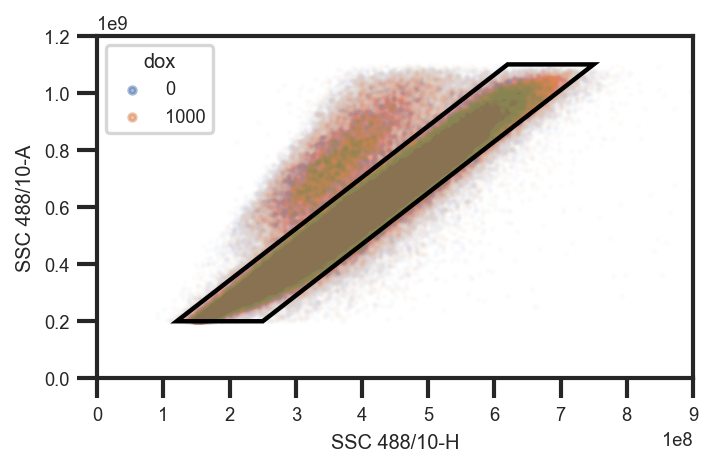

In [7]:
# set a polygon gate for single cells 'P2'
op_2 = flow.PolygonOp(name='P2',
                 xchannel='SSC 488/10-H',
                 ychannel='SSC 488/10-A',
                 vertices=[(1.2e8, 2.0e8),
                           (6.2e8, 1.1e9),
                           (7.5e8, 1.1e9),
                           (2.5e8, 2.0e8)])
ex_2 = op_2.apply(ex_1)

# view gate
op_2.default_view(xscale = 'linear',
                  yscale = 'linear',
                  huefacet = 'dox',
                  subset='(P1 == True)').plot(ex_2, alpha = 0.01, xlim=(0, 0.9e9), ylim=(0, 1.2e9))
                #   subset='(P1 == True)').plot(ex_2, alpha = 0.01, xlim=(0, 1.8e9), ylim=(0, 2.2e9))

# Check that most cells are singlets
P2_pos = len(ex_2.data[(ex_2.data['P2']==True) & (ex_2.data['P1']==True)])
P2_neg = len(ex_2.data[(ex_2.data['P2']==False) & (ex_2.data['P1']==True)])
P2_percent = str(round(100*P2_pos/(P2_pos + P2_neg), 1)) + '%'
print('Percent of P1 events in P2 gate: %s' % P2_percent)

Percent of P1P2 events in P3 gate: 93.9%


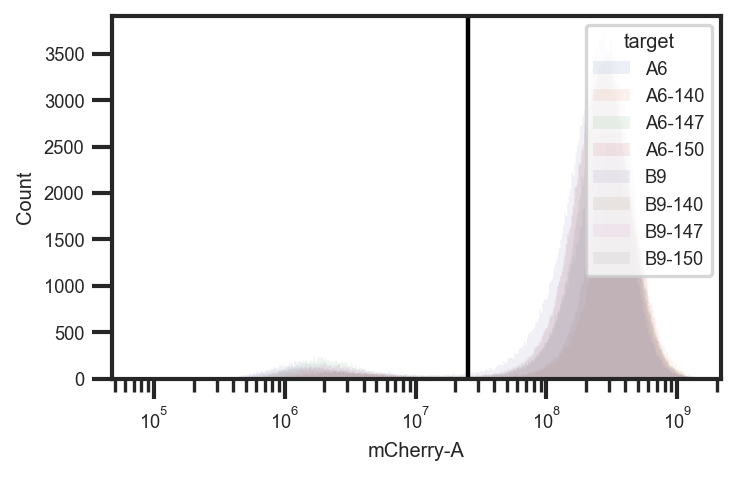

In [8]:
# set a polygon gate for single cells 'P2'
op_3 = flow.ThresholdOp(name='mCh_pos',
                 channel='mCherry-A',
                 threshold=2.5e7)
ex_3 = op_3.apply(ex_2)

# view gate
op_3.default_view(scale = 'log',
                  huefacet = 'target',
                  subset='(P1 == True)').plot(ex_3, alpha = 0.1) # , xlim=(0, 0.9e9), ylim=(0, 1.2e9))

# Check that most cells are singlets
P3mCh_pos = len(ex_3.data[(ex_3.data['mCh_pos']==True) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3mCh_neg = len(ex_3.data[(ex_3.data['mCh_pos']==False) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3_percent = str(round(100*P3mCh_pos/(P3mCh_pos + P3mCh_neg), 1)) + '%'
print('Percent of P1P2 events in P3 gate: %s' % P3_percent)

In [9]:
df = ex_3.data
df = df[(df['P2']==True)&(df['P1']==True)&(df['mCh_pos']==True)]
df.rename(columns={'mCitrine-A': 'Citrine-A', 'mCitrine-H': 'Citrine-H', 'mCitrine-W': 'Citrine-W'}, inplace = True)

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
targetList

['A6', 'A6-140', 'A6-147', 'A6-150', 'B9', 'B9-140', 'B9-147', 'B9-150']

In [16]:
targetList = sorted(df['target'].unique().tolist())
doxList = sorted(df['dox'].unique().tolist())
recList = sorted(df['rec'].unique().tolist())
relList = sorted(df['rel'].unique().tolist())
repList = sorted(df['rep'].unique().tolist())
cond_rename = targetList# ['just start', 'safe', '-12 kb', '-8 kb', '-5 kb', '-3.2 kb', '-1.8 kb', '1.8 kb', '3.2 kb', '5 kb', '8 kb', '12 kb']

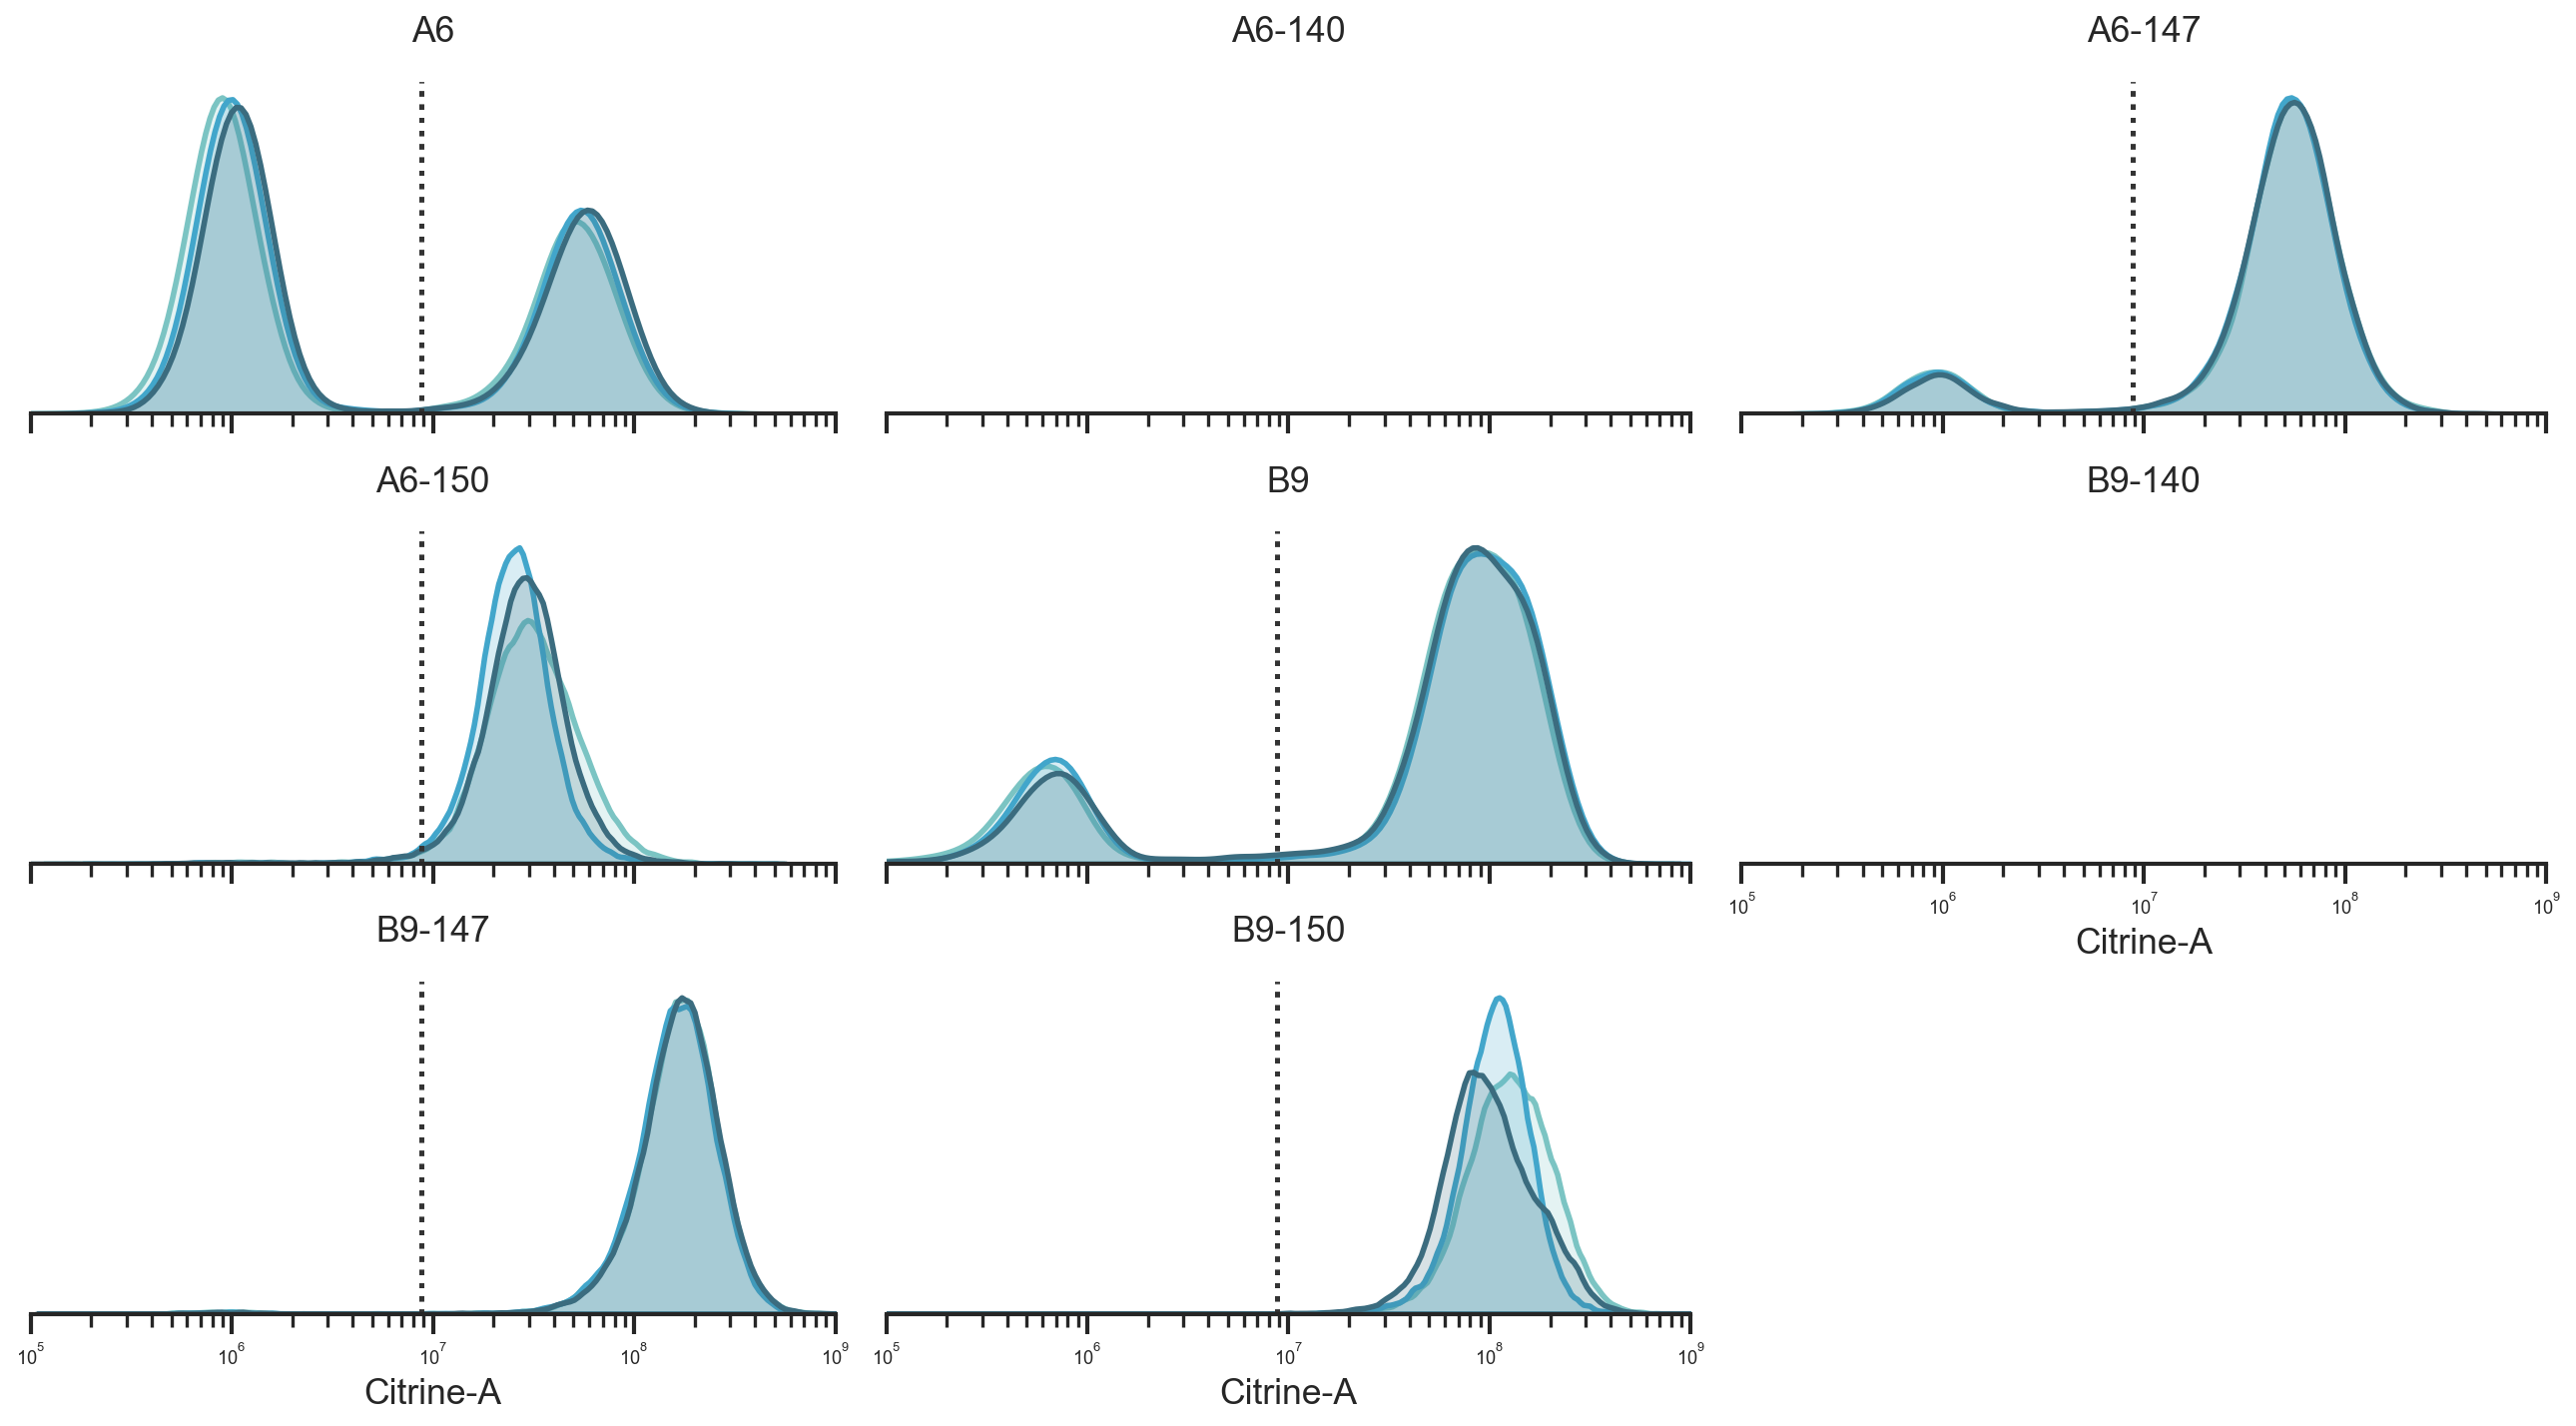

In [17]:
# plot citrine for a given day
day_index = 1.0
citrine_threshold = 8.8e6

data = df[df['rec'] == day_index]
# data = df
f = sns.FacetGrid(
    data = data,
    col = 'target',
    col_wrap = 3,
    col_order = targetList,
    hue='rep',
    palette = 'GnBu_d',
    sharey = False,
    height = 3,
    aspect = 1.8,
    margin_titles = False,
)

for ax, title, name in zip(f.axes.flat, targetList, cond_rename):
    ax.text(0.5, 1.15, name, transform=ax.transAxes, ha='center', va='center', size = 16)
    ax.set_xlabel('Citrine-A', size = 16)
    ax.set_xlim([1e5, 10e8])
    # text = f"{round(100 * np.mean(cto_fracs[labelDict[title], :, day_index]), 1)}%"
    # ax.text(0.1, 0.5, text, transform=ax.transAxes, ha='left', va='center', size=13)

f.map(sns.kdeplot, 'Citrine-A', log_scale = True, bw_adjust = 0.6, fill=True, alpha=0.2, linewidth=2.5)
f.map(plt.axvline, x=citrine_threshold, ls=':', color='#333333')

f.set_titles('')
f.set(yticks = [], ylabel = '')
f.despine(left=True)
plt.tight_layout()
# plt.savefig(f'ODR007_day{days[day_index]}_Citrine.png', dpi = 300)

## calculate silenced fraction

In [18]:
targetList = [targetList[i] for i in [0,2,3,4,6,7]]
targetList

['A6', 'A6-147', 'A6-150', 'B9', 'B9-147', 'B9-150']

In [19]:

sil_fracs = np.empty((len(targetList), len(doxList), len(recList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dx, dox in enumerate(doxList):
        dataB = dataA[dataA['dox'] == dox]
        for rc, rec in enumerate(recList):
            dataC = dataB[dataB['rec'] == rec]
            for rp, rep in enumerate(repList):
                data = dataC[dataC['rep'] == rep]
                all = len(data)
                if all > 0:
                    citrine_off = len(data[(data["Citrine-A"] < citrine_threshold)])
                    sil_fracs[lb, dx, rc, rp] = citrine_off/all


In [20]:
A6avg = np.mean(sil_fracs[0:int(len(targetList)/2),:,:,:], axis = 3).flatten()
A6std = np.std(sil_fracs[0:int(len(targetList)/2),:,:,:], axis = 3).flatten()
B9avg = np.mean(sil_fracs[int(len(targetList)/2):,:,:,:], axis = 3).flatten()
B9std = np.std(sil_fracs[int(len(targetList)/2):,:,:,:], axis = 3).flatten()
B9sqavg = np.mean(np.sqrt(sil_fracs[int(len(targetList)/2):,:,:,:]), axis = 3).flatten()
B9sqstd = np.std(np.sqrt(sil_fracs[int(len(targetList)/2):,:,:,:]), axis = 3).flatten()

A6avg = A6avg[~np.isnan(A6avg)]
A6std = A6std[~np.isnan(A6std)]
B9avg = B9avg[~np.isnan(B9avg)]
B9std = B9std[~np.isnan(B9std)]
B9sqavg = B9sqavg[~np.isnan(B9sqavg)]
B9sqstd = B9sqstd[~np.isnan(B9sqstd)]

## scatter plot with fitting curves

0.020551411168366483
[0.37875694]
0.0020569732006985365
[0.58543013]
0.007846805843553874
[0.7426388]


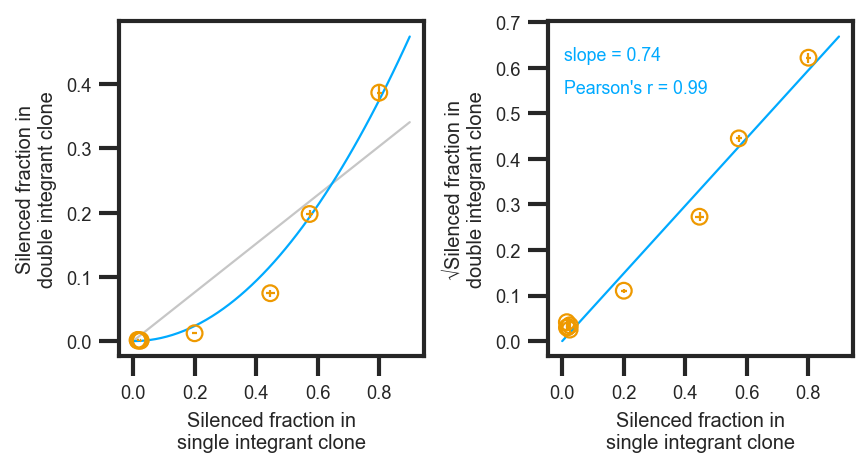

In [21]:
def linearfunc(x, a):
    return a*x

def quadraticfunc(x, a):
    return a*x**2

linfitcolor = ['#aaaaaaaa','#00aaff']
ylabels = ['Silenced fraction in\ndouble integrant clone','√Silenced fraction in\ndouble integrant clone']

fig = plt.figure(figsize = (5.5, 3))

for ii in range(2):
    if ii == 0:
        ydata = B9avg
        yerrdata = B9std
    elif ii == 1:
        ydata = B9sqavg
        yerrdata = B9sqstd

    ax = plt.subplot(1,2,ii+1)
    xdata = np.linspace(0, 0.9, 50)
    popt, pcov, infordict, mesg, ier = scipy.optimize.curve_fit(linearfunc, A6avg, ydata, full_output=True)
    plt.plot(xdata, linearfunc(xdata, *popt),'-',color=linfitcolor[ii],linewidth=1, zorder=1)
    # text = 'error = %0.4f' % np.sum(infordict['fvec']**2) # residual sum of squares
    if ii == 1:
        text = 'slope = %0.2f' % popt[0]
        ax.text(0.05, 0.9, text, transform=ax.transAxes, ha='left', va='center', size=8,color=linfitcolor[ii])
        text = 'Pearson\'s r = %0.2f' % scipy.stats.pearsonr(A6avg, ydata)[0]
        ax.text(0.05, 0.8, text, transform=ax.transAxes, ha='left', va='center', size=8,color=linfitcolor[ii])

    # print(sklearn.metrics.r2_score(ydata, linearfunc(A6avg, *popt))) # R2
    print(np.sum(infordict['fvec']**2)) # same as     print(np.sum((ydata - linearfunc(A6avg, *popt))**2))
    print(popt)

    if ii == 0:
        popt, pcov, infordict, mesg, ier = scipy.optimize.curve_fit(quadraticfunc, A6avg, ydata, full_output=True)
        plt.plot(xdata, quadraticfunc(xdata, *popt),'-',color='#00aaff',linewidth=1, zorder=2)
        # print(sklearn.metrics.r2_score(ydata, quadraticfunc(A6avg, *popt)))
        print(np.sum(infordict['fvec']**2)) # same as         print(np.sum((ydata - quadraticfunc(A6avg, *popt))**2))
        print(popt)
        # text = 'error = %0.4f' % np.sum(infordict['fvec']**2) # f"{round(100 * np.mean(cto_fracs[labelDict[title], :, day_index]), 1)}%"
        # ax.text(0.1, 0.7, text, transform=ax.transAxes, ha='left', va='center', size=8,color='#00aaff')

    plt.scatter(A6avg, ydata, s=50, zorder=3,edgecolors='#ee9900',facecolors='none', lw=1)
    plt.errorbar(A6avg, ydata, xerr=A6std, fmt='none', lw=1, color='#ee9900', zorder=4)
    plt.errorbar(A6avg, ydata, yerr=yerrdata, fmt='none', lw=1, color='#ee9900', zorder=4)

    plt.xlabel('Silenced fraction in\nsingle integrant clone')
    plt.ylabel(ylabels[ii])

plt.tight_layout()
plt.show()
# fig.savefig('memory_single-double_comparison.pdf', dpi = 300)

In [22]:
sil_fracs.shape

(6, 2, 2, 3)

In [23]:
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_KRAB/'
with open(ZE5rawdatapath+'KRAB_A6vsB9_OFFfracDay16_tgt-dox-rec-rep.npy', 'wb') as f:
    np.save(f, sil_fracs, allow_pickle=False)

In [25]:
recList

[1.0, 5.0]